# Writing Efficient R Code
## -- DataCamp - R programmer Career Track - Course 4 --

 To use this code, select the R environment in Anaconda
 
 **Used packages**
 - benchmarkme
 - microbenchmark
 - profvis
 - parallel
 
**Table of content**

- [&nbsp;&nbsp;1. Benchmarking](#toc_98321_1)
- [&nbsp;&nbsp;2. Memory allocation and optimization](#toc_98321_2)
- [&nbsp;&nbsp;3. Code profiling](#toc_98321_3)
- [&nbsp;&nbsp;4. Parallel programming](#toc_98321_4)

**Set environment and plot size**

In [97]:
options(repr.plot.width=6, repr.plot.height=6)
library(benchmarkme)
library(microbenchmark)
library(profvis)

poke <- read.csv("data/pokemon.csv")

Note: if the above code return an error message:
- Check that the correct R environment is selected in Anaconda
- Restart computer

<a name="toc_98321_1"></a>
## 1.   Benchmarking

We use R because it is good with statistics however, R has the unfortunate reputation for being slow. With the advent of big data and complex statistical algorithms, we may have to **optimize** our code. 

 Donald Knuth said: *"premature optimization is the root of all evil"*. That is, only optimize when necessary. 
 
Benchmarking is basically when we are timing multiple functions and selecting the best solution. An important starting point is to **keep R up-to date**! New versions of R rarely break code. and it often provide speed boosts, such as improved handling of data frames, so your code just goes a little bit faster. Main R releases happen every April, with smaller incremental updates occurring throughout the year. It is also a good idea to use an environment manager system, like Anaconda.

**Check current R version**

In [19]:
version
version$major
version$minor

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 

[1] "4"

[1] "1.3"

**Check how good our system is with benchmarkme**

In [18]:
benchmarkme::get_ram()
benchmarkme::get_cpu()

17.2 GB

$vendor_id
[1] "GenuineIntel"

$model_name
[1] "Intel(R) Core(TM) i5-9500T CPU @ 2.20GHz"

$no_of_cores
[1] 6

# Programming benchmarks (5 tests):

	3,500,000 Fibonacci numbers calculation (vector calc): 0.617 (sec).

	Grand common divisors of 1,000,000 pairs (recursion): 0.983 (sec).

	Creation of a 3,500 x 3,500 Hilbert matrix (matrix calc): 0.297 (sec).

	Creation of a 3,000 x 3,000 Toeplitz matrix (loops): 1.19 (sec).

	Escoufier's method on a 60 x 60 matrix (mixed): 0.78 (sec).

# Matrix calculation benchmarks (5 tests):

	Creation, transp., deformation of a 5,000 x 5,000 matrix: 0.7 (sec).

	2,500 x 2,500 normal distributed random matrix^1,000: 0.817 (sec).

	Sorting of 7,000,000 random values: 0.73 (sec).

	2,500 x 2,500 cross-product matrix (b = a' * a): 0.17 (sec).

	Linear regr. over a 5,000 x 500 matrix (c = a \ b'): 0.01 (sec).

# Matrix function benchmarks (5 tests):

	Cholesky decomposition of a 3,000 x 3,000 matrix: 0.13 (sec).

	Determinant of a 2,500 x 2,500 random matrix: 0.167 (sec).

	Eigenvalues of a 640 x 640 random matrix: 0.273 (sec).

	FFT over 2,500,000 random values: 

Press return to get next plot  


You are ranked 66 out of 93 machines.



Press return to get next plot  


You are ranked 31 out of 93 machines.



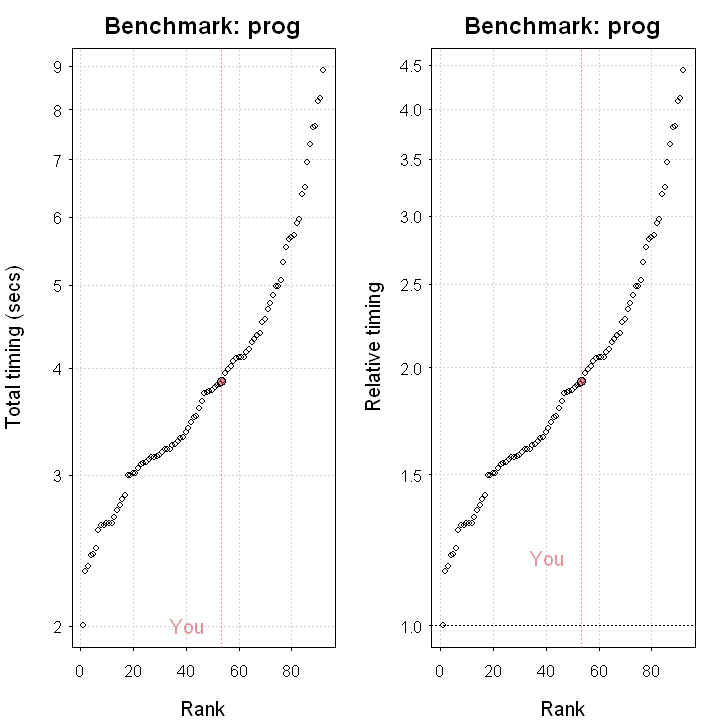

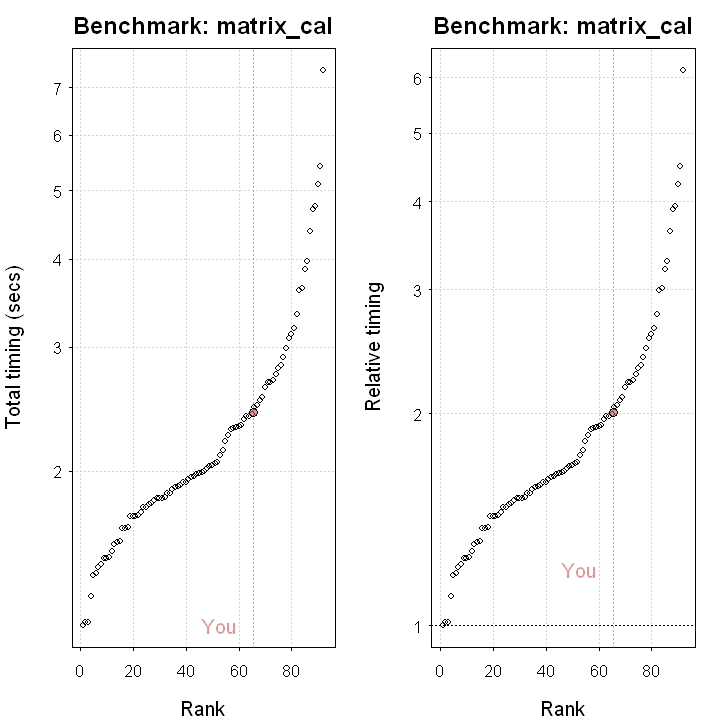

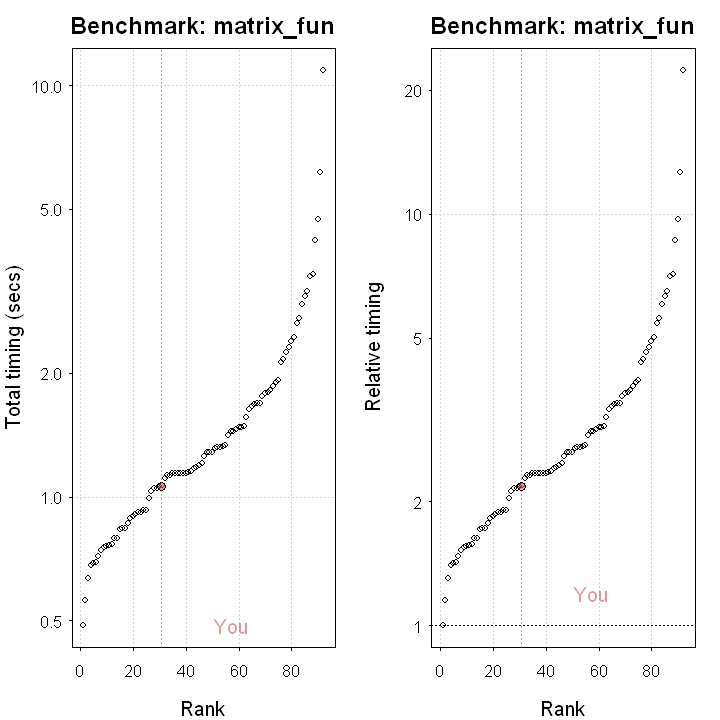

In [14]:
res <- benchmarkme::benchmark_std(runs = 3)
plot(res)

☝️ These benchmarks are standard R operations such as loops and matrix calculations. On a standard machine, this code will take around four minutes or so to run. Once the benchmark has completed, you can compare your results to other users with the `plot` function. This method generates a set of plots that allows you to compare your machine to theirs. The left plot is measured in seconds, whereas the right plot is relative time compared to the fastest machine. Each point on plot represents a machine. My computer is highlighted by the vertical line and on the matric_fun category I'm ranked ~30th out of ~90 machines. After you've examined the results, you should upload them to help other people via the upload_results function. 

There are other functions like, e.g. `benchmark_io(runs = 1, size = 5)` records the length of time it takes to read and write a 5MB file.

**Check and compare code run times**

if our code is too slow, you may need to make your code faster! To determine if it is worth changing your code, you need to compare your existing solution with one or more alternatives. This is what we mean by **benchmarking**. The concept is straightforward. You simply time how long each solution takes, and all things being equal, select the fastest.

- `system.time()` - shows how long it takes to run the a certain code. The most important number is the **elapsed** time.
- `microbenchmark()` - from the microbenchmark package, it can compare multiple function calls.
- `benchmark_stb()` - from the `benchmarkme` package ahows how good our machine is. Call `plot()` on the output to visualize the comparison.

In [3]:
colon <- function(n){
    1:n
}

seq_def <- function(n){
    seq(1, n)
}

seq_by <- function(n){
    seq(1, n, by = 1)
}

In [5]:
# Create a sequence of numbers
n <- 1e8
system.time(colon(n))
system.time(seq_def(n))
system.time(seq_by(n))

   user  system elapsed 
      0       0       0 

   user  system elapsed 
      0       0       0 

   user  system elapsed 
   0.89    0.19    1.10 

In [72]:
mbm1 <- microbenchmark(
    colon(n),
    seq_def(n), 
    seq_by(n)
    )

summary(mbm1)

expr,min,lq,mean,median,uq,max,neval
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
colon(n),300,400,495,500,500,2300,100
seq_def(n),4300,4600,5884,4900,5300,71600,100
seq_by(n),15500,16000,18371,16400,16700,74500,100


<a name="toc_98321_2"></a>
## 2.   Memory allocation and optimization

When we assign a variable, R has to allocate memory in RAM. This takes some time, so an important way to make your code run faster is to minimize the amount of memory allocation R has to perform. The  most important rules to **optimize** our code:
- Never grow a vector in R, instead always pre-allocate vectors
- If possible, use vectorized solutions instead of loops. The less function calls and assignment operators used the faster the code is.
- Working with matrices is faster than data frames.
- Use specialized and more optimized functions instead of `apply()`. E.g. `RowSums(df)` is better than `apply(df, 1, sum)`
- Use `&&` intead of `&` when working with logical vectors of length 1 
    - The `&` operator will always evaluate both its arguments, i.e. if we type `x & y`, R will always try to work out what `x` and `y` are. There are some cases where this is inefficient. For example, if `x` is FALSE, then `x & y` will always be FALSE, regardless of the value of `y`. The `&&` operator takes advantage of this trick, and doesn't bother to calculate `y` if it doesn't make a difference to the overall result. Note that `&&` only works on single logical values, but `&` also works on vectors of length greater than 1.
- Run the code parallel (see later)

In this code, if is_double[1] is FALSE we don't need to evaluate 

**Code vectorization**

In [28]:
n <- 5

# The best way
(x <- 1:n)

# Not so bad
x <- vector("numeric", n) # preallocate the vector to length n
for(i in 1:n){
  x[i] <- i
  print(x)
}


# Don't ever do this, can be very time consuming
x <- NULL
for(i in 1:n){
  x <- c(x, i)
  print(x)  # growing vector
}


[1] 1 2 3 4 5

[1] 1 0 0 0 0
[1] 1 2 0 0 0
[1] 1 2 3 0 0
[1] 1 2 3 4 0
[1] 1 2 3 4 5
[1] 1
[1] 1 2
[1] 1 2 3
[1] 1 2 3 4
[1] 1 2 3 4 5


☝️ 
- Method 1: runs almost instantly.
- Method 2: The memory allocation happens only once when we **pre-allocate** the vector, which is pretty quick. 
- Method 3: A big no-no! When n is large it can take over an hour and the code will be unusable. The reason for this slowdown is a constant request by the for loop for more memory. Since **requesting memory is a relatively slow operation**, this introduces a potentially **fatal bottleneck**. 
Conclusion: <u>Never, ever grow a vector in R!</u>

When we call a base R function, we eventually call some **C** or **FORTRAN** code. The underlying code is heavily optimized. A general rule for making code run faster is to access the underlying code as quickly as possible; the fewer functions call the better. This usually means **vectorized code**.

Many R functions are vectorized. Some functions, such as `rnorm` take in a single number, but return a vector. Other functions, such as `mean`, take in a vector and return a single value. 

In [ ]:
n <- 1000

# vectorized solution
x <- rnorm(n)

# For loop solution
x <- vector("numeric", n)
for(i in seq_along(x)){
  x[i] <- rnorm(1)
}

☝️ 
- In the for loop, we have *n* calls to the rnorm function. if *N* is large? this means many many `rnorm()` **function calls** and many many `<-` **assignment operations**. This is rather time consuming. 
- In the vectorized solution there is a single call of the `rnorm()` function. Also, we have just a single assignment operation

Conclusion: <u>use a vectorized solution wherever possible.</u>

In [29]:
# Initial code
n <- 100
total <- 0
x <- runif(n)
for(i in 1:n) 
    total <- total + log(x[i])

# Vectorized (better) code doing the same task
log_sum <- sum(log(x))

**Data frames vs matrices**

A data frame is actually a list of vectors where each column is a single vector. This has implications for storage. Suppose you were in a library and wanted twenty six books where the authors surname starts with A. This is easy. You just need to locate the correct shelf and take the books. This is what happens when we retrieve a column from the data frame. We locate one starting position of the column, and take what we need. However if you want twenty six books where the authors' surname have a different starting letter, then you need to go round the entire library and locate twenty six separate shelves. This is what happens when you retrieve a row. You need to find the starting locations of every single column and select what you require. A potentially time consuming job.

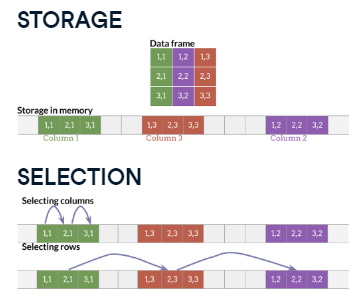
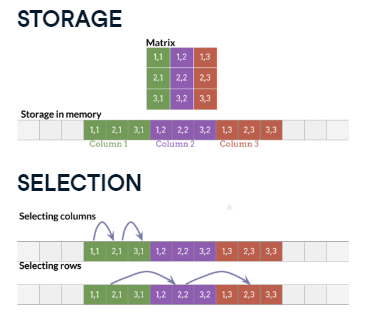

A matrix (bottom image) is similar to a data frame, but it can only contain a single data type. This makes storage much easier; as the entire matrix is stored in one continuous block. Selecting columns is easy - we find the start of the column and retrieve the data. Selecting rows is also straightforward. Find the first value then increment a constant amount along the matrix.

<a name="toc_98321_3"></a>
## 3.   Code profiling

**Bottle neck**: a rate limiting section of code that esentially slows down the overall speed of execution. 
The problem is that you don't always know where the bottle neck is and which part to fix. The correct way of determining where the hold up lies, is to use code profiling.

**Code profiling**:
You run your code and take snapshots, every few milliseconds, of what the program is doing at regular intervals. This gives you data on how long each function took to run. R comes with a built in tool for code profiling called `R prof`. Unfortunately, R prof isn't that user friendly. An alternative way of profiling is to use the `profvis` package. Actually, profvis is already built-in in`R Studio`: highlighting the code we want to profile, then go to `Profile -> Profile Selected lines`. It records the call stack at regular intervals.

In [55]:
profvis({
  reps <- 10000
  n <- 100
  beta0 <- 2
  beta1 <- .7
  
  save <- vector()
  
  save <- for (i in 1:reps) {
    x <- rnorm(n)
    y <- beta0 + beta1*x + rnorm(n)
    
    # Add rounding. Since we're dealing with standardized data, round to 2 decimals.
    badinterviewer <- sample(1:n, .25*n, replace = FALSE)
    x[badinterviewer] <- ceiling(x[badinterviewer])
    
    coef <- lm(y ~ x)$coef[2]
    save <- c(save, coef)
  }
  save <- data.frame(save)
  ggplot(save, aes(x = save)) + geom_density() + geom_vline(xintercept = beta1)
})

HTML widgets cannot be represented in plain text (need html)

☝️ The **flame graph** below is mostly useless here because we have so much going on. The **source code** above that indicates much more cleanly where the bottlenecks lie. The columns next to the code represent the memory regained during garbage collection (The negative value; not really that useful), the memory allocated at that call, and the time (in ms) spent in each line.

*Note: If the top half of Flame Graph is blank, it is because the content is all internal R code. We can try to use `options(keep.source=TRUE)`*

From this, we can clearly see that the `lm` call is the most wasteful. Usually, built-in R codes are tightly optimized, but here’s a situation where it isn’t. And the main cause is that `lm` does far more than we need here! All we want here is the coefficient of a linear model but `lm` returns far more. We’ve got two options.

To optimize this code, we can
- keep the `lm` function
- write our own solver as `solve(t(x) %*% x) %*% (t(x) %*% y)` that computes the least squares estimates of the coefficients in a linear regression model using the matrix algebra formula (X'X)^-1 X'Y, where X is the matrix of predictor variables and Y is the vector of response variables.
- use `.lm.fit`, which takes in only a design matrix (with the intercept already added) and a response and is designed to run much quicker.

To compare these solutions, we can use the `microbenchmark` package mentioner earlier.

In [66]:
n <- 100
beta0 <- 2
beta1 <- .7
x <- rnorm(n)
y <- beta0 + beta1*x + rnorm(n)

badinterviewer <- sample(1:n, .25*n, replace = FALSE)
x[badinterviewer] <- ceiling(x[badinterviewer])

y <- matrix(y, ncol = 1)
x <- cbind(1, x)

library(microbenchmark)

mbm <- microbenchmark(lm(y ~ x),
                       solve(t(x) %*% x) %*% (t(x) %*% y),
                       .lm.fit(x, y))

In [68]:
summary(mbm)

expr,min,lq,mean,median,uq,max,neval
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lm(y ~ x),541.1,596.35,676.382,623.55,687.80,1364.1,100
solve(t(x) %*% x) %*% (t(x) %*% y),28.5,34.90,54.122,54.15,67.65,139.8,100
".lm.fit(x, y)",4.8,6.40,11.121,10.35,11.40,94.6,100


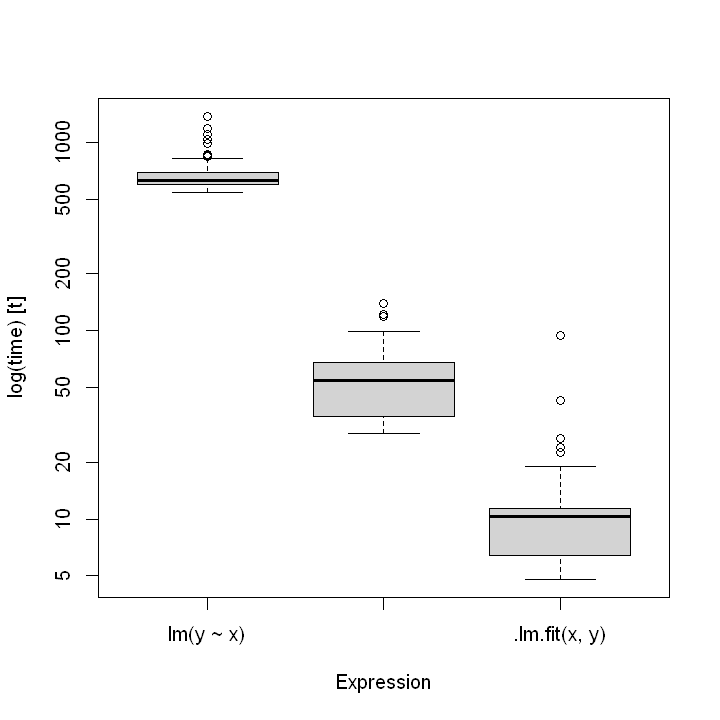

In [69]:
boxplot(mbm)

<a name="toc_98321_4"></a>
## 4.   Parallel programming

- **CPU** - The CPU is the brains of the computer. The faster the CPU, the faster your code will run. For the last decade or so, the speed of a single CPU has slowly stabilized. The reason is that as they got faster, they become hotter and it's a problem keeping them cool. So computer manufacturers moved from making very fast single core machines, to multi-core machines. 
- Unfortunately **R is single threaded**. This means that by default it will only use a single core. But by using the `parallel` base package you can make sections of your code use all available cores.

First, let's investigate our hardware:
- The `detectCores()` function in the `parallel` package returns the number of cores on the machine. In this case, 6. 
- The ˛`benchmarkme` package extends this function via `get_cpu`. So my machine has an intel i5 chip with 6 cores. This gives the potential for a six fold speed-up.

In [75]:
parallel::detectCores()

[1] 6

In [76]:
benchmarkme::get_cpu()

$vendor_id
[1] "GenuineIntel"

$model_name
[1] "Intel(R) Core(TM) i5-9500T CPU @ 2.20GHz"

$no_of_cores
[1] 6

However, before we start using multiple cores, we need to be aware of its disadvantages. Mainly that the vast majority of statistical methods just haven't been designed with parallel computing in mind. 

<u>So what type of problems can exploit multi core CPUs? </u>

Suppose you want to perform 6 Monte-Carlo simulations. A standard way is to construct a for loop, and at each iteration you simulate a realization of the process. So my desktop machine has 6 cores, so each core would simulate a single realization. Once all the cores are finished, we would combine the results. 

```r
for(i in 1:6){
    sims[i] <- monte_carlo_simulation()
}
```
This is the easiest type of parallel computing and is known as **embarrassingly parallel**, since little effort is needed to separate the problem into separate tasks. Let's consider a different loop.

**Not everything runs in parallel**

The loop below sets the value of `x[i]` to the previous value. After running the loop, all values of the vector `x` are equal to 1. If we had six cores, could we run this loop in parallel? The short, sad answer is no. In parallel computing we can't guarantee the order of operations. So if core 4 was executed first, it would need the value of `x[3]` which is currently 3 and not 1.

```r
x <- 1:6
for(i in 2:6){
    x[i] <- x[i-1]
}
```

A general advice: if you can write your loop in reverse, there's a good chance you can use multi-core computing. E.g. `for(i in 1:6)`... gives the same overall result as `for(i in 6:1)`.

In [78]:
total <- no_of_rolls <- 0 # Initialize
while(total < 10) {
  total <- total + sample(1:6, 1)

  if(total %% 2 == 0) total <- 0  # If even. Reset to 0

  no_of_rolls <- no_of_rolls + 1
}
no_of_rolls

[1] 17

☝️ This code cannot be run is parallel because it's a sequential algorithm. The ith value depends on the previous value.

In [79]:
play <- function() {
  total <- no_of_rolls <- 0
  while(total < 10) {
    total <- total + sample(1:6, 1)

    # If even. Reset to 0
    if(total %% 2 == 0) total <- 0 
    no_of_rolls <- no_of_rolls + 1
  }
  no_of_rolls
}

results <- numeric(100)
for(i in seq_along(results)) 
    results[i] <- play()

☝️ The above for loop can be run parallel, in fact it is embarrassingly parallel. We can simulate the games in any order.

**Converting code to parallel**
- Set the number of cores we want to use - If I intend to use my machine for something else such as email, then I would specify the number of cores minus 1. If the machine was purely focused on the computation, then I would set it to the maximum number of cores.
- Create a cluster object - This creates copies of R running in parallel. The argument in `makeCluster` specifies the number of cores to use.
- Swap our functin with its parallel counterpart
- Finally, to free up resources, we close the cluster via the `stopCluster` function. 

What's really neat about this approach, is there is little extra code when switching to the parallel version. We simply: Load the package, Create a cluster, Change to parApply, Close the cluster.

However, we must be aware that when we use multiple cores, this requires communication between CPUs. If the job is already very fast, then this communication can swamp the potential benefit and actually slow done our code! Therefore you should benchmark both the serial and parallel options!

In [88]:
m <- matrix(rnorm(100000), ncol = 10)
res <- apply(m, 1, median) # apply is like a for loop on each row|column of a matrix

1) Set the number of cores we want to use:

In [87]:
cores <- parallel::detectCores()
copies_of_r <- cores - 1 # good practice to use max cores - 1, so we have 1 remaining core for other tasks

2) Create a cluster object:

In [90]:
cl <- parallel::makeCluster(copies_of_r)

3) Swap our function, `apply`, with its parallel counterpart, `parApply()`. Its first argument is the cluster object!:

In [93]:
res2 <- parallel::parApply(cl, m, 1, median) 

4) Close the cluster:

In [95]:
parallel::stopCluster(cl)

**Run bootstrap in parallel**

[1] 0.4386871

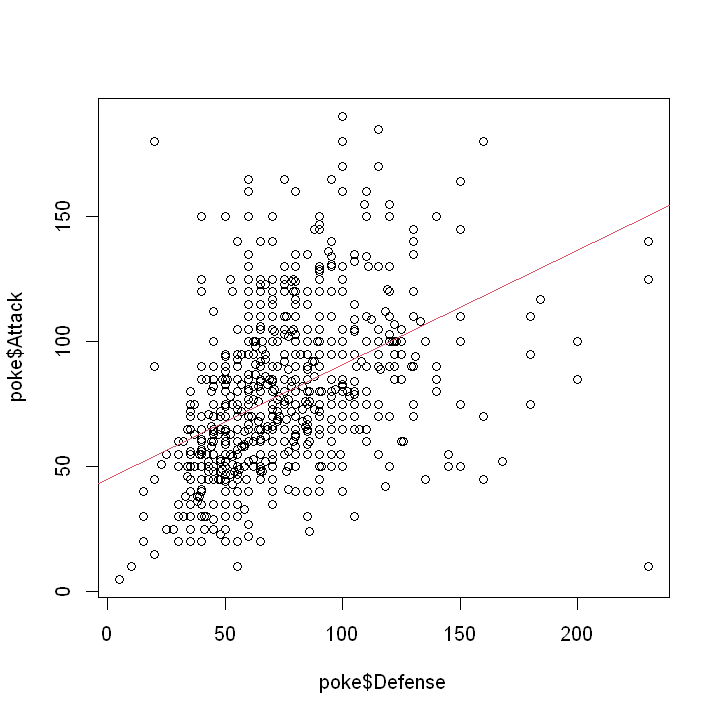

In [108]:
plot(poke$Defense, poke$Attack)
abline(lm(poke$Attack ~ poke$Defense), col = 2)
cor(poke$Attack, poke$Defense)

We notice that there appears to be a positive relationship between pokemon defense and attack. Getting a handle on the uncertainty of the correlation estimate is bit tricky. One easy solution is to use bootstrapping.

The idea behind the bootstrap algorithm is that in a perfect world, we would just go and get another sample from the population. However in practice this isn't possible. So instead of sampling from the population, you re-sample using your original data set. Essentially there are only two steps. First, sample from the original data set with replacement; note the key word: replacement. This means a data point from the original data set can appear multiple times in your new sample. So if your original data set was of size one hundred, our new bootstrapped sample would also be one hundred. Second calculate the correlation coefficient of the new data set. These two steps are repeated multiple times. The distribution of correlation values, gives us a measure of uncertainty about the correlation statistic. 

To run in parallel you begin by creating a function that creates a single bootstrap. This function has a single argument - the Pokemon data set. You can wrap this function with sapply and hence parSapply. Let's switch to parallel.

In [120]:
# Solution for one core

bootstrap <- function(data){
    s <- sample(1:nrow(data), replace = TRUE)
    new_data <- data[s,]
    cor(new_data$Attack, new_data$Defense)
    }

sim <- sapply(1:100, function(i) bootstrap(poke))

Convert this to parallel:

Begin by creating a cluster object. Then we have an additional step involving `clusterExport`. This is where you explicitly export functions and data sets. You need this step since `makeCluster` doesn't copy all objects by default for efficiency reasons. After exporting, you change to `parSapply`; and shutdown the cluster:

In [119]:
# Converting to parallel

no_of_cores <- 5
cl <- parallel::makeCluster(no_of_cores)

parallel::clusterExport(cl, c("bootstrap", "poke"))

sim2 <- parallel::parSapply(cl, 1:100, function(i) bootstrap(poke))
          
parallel::stopCluster(cl)

But was the effort of converting this code to run in parallel worth the effort?

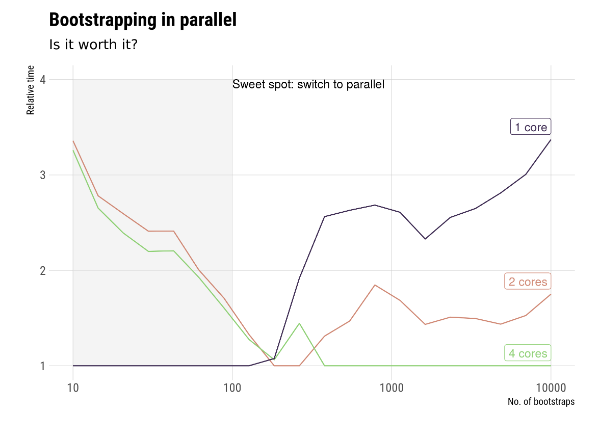

The timing graph shows the relative speed for running the processes in parallel compared to the single core version. The blue line is the relative time when using a single core. When the number of bootstraps is less than one hundred, it's quicker to stick with one core. When you carry out more than one hundred bootstraps, the computation time outweighs the extra overhead of CPU communication and moving to parallel is worthwhile. This graph is typical. It's not always faster to run code in the parallel. We need to take a step back and determine if it's worthwhile for our particular problem. However, the cost of trying things in parallel is relatively low.